In [1]:
import pandas as pd
import os
import re
import json
import yaml
from glob import glob
from tqdm import tqdm
from pprint import pprint
import torch
import pytorch_lightning as pl
from rouge import Rouge # 모델의 성능을 평가하기 위한 라이브러리입니다.

from torch.utils.data import Dataset , DataLoader
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, BartForConditionalGeneration, BartConfig
from transformers import T5TokenizerFast, T5ForConditionalGeneration, T5Config
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer
from transformers import Trainer, TrainingArguments
from transformers import EarlyStoppingCallback

import wandb # 모델 학습 과정을 손쉽게 Tracking하고, 시각화할 수 있는 라이브러리입니다.

# visualization
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/NanumFont/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Tokenizer 정의

In [2]:
# config 설정에 tokenizer 모듈이 사용되므로 미리 tokenizer를 정의해줍니다.
model_dir = "lcw99/t5-base-korean-text-summary"
tokenizer = T5TokenizerFast.from_pretrained(model_dir) 

# https://huggingface.co/paust/pko-t5-base
# transformers 의 API 를 사용하여 접근 가능합니다. 
# tokenizer 를 사용할때는 T5Tokenizer 가 아니라 T5TokenizerFast 를 사용해주십시오. 
# model 은 T5ForConditionalGeneration 를 그대로 활용하시면 됩니다.

# Config 정의

In [3]:
config_data = {
    "general": {
        "data_path": "../../data", # 모델 생성에 필요한 데이터 경로를 사용자 환경에 맞게 지정합니다.
        "model_name": f"{model_dir}", # 불러올 모델의 이름을 사용자 환경에 맞게 지정할 수 있습니다.
        "output_dir": "./" # 모델의 최종 출력 값을 저장할 경로를 설정합니다.
    },
    "tokenizer": {
        "encoder_max_len": 1000,
        "decoder_max_len": 125,
        "bos_token": f"{tokenizer.bos_token}",
        "eos_token": f"{tokenizer.eos_token}",
        # 특정 단어들이 분해되어 tokenization이 수행되지 않도록 special_tokens을 지정해줍니다.
        "special_tokens": ['#Person3#', '#PhoneNumber#', '#Person5#', '#PassportNumber#', '#DateOfBirth#', '#Address#', '#Person6#', 
                           '#CarNumber#', '#SSN#', '#Person7#', '#CardNumber#', '#Person4#', '#Person2#', '#Person#', '#Email#', '#Person1#']
    },
    "training": {
        "overwrite_output_dir": True,
        "num_train_epochs": 50,
        "learning_rate": 1e-5,
        "per_device_train_batch_size": 8, # 50
        "per_device_eval_batch_size": 4, # 32
        "warmup_ratio": 0.1,
        "weight_decay": 0.01,
        "lr_scheduler_type": 'cosine',
        "optim": 'adamw_torch',
        "gradient_accumulation_steps": 1,
        "evaluation_strategy": 'epoch',
        "save_strategy": 'epoch',
        "save_total_limit": 7,
        "fp16": True,
        "load_best_model_at_end": True,
        "seed": 42,
        "logging_dir": "./logs",
        "logging_strategy": "epoch",
        "predict_with_generate": True,
        "generation_max_length": 150,
        "do_train": True,
        "do_eval": True,
        "early_stopping_patience": 5, # 3
        "early_stopping_threshold": 0.0001, # 0.001
        "report_to": "wandb" # (선택) wandb를 사용할 때 설정합니다.
    },
    # (선택) wandb 홈페이지에 가입하여 얻은 정보를 기반으로 작성합니다.
    "wandb": {
        "entity": "entity_name",
        "project": "project_name",
        "name": "name"
    },
    "inference": {
        "ckt_path": "model ckt path", # 사전 학습이 진행된 모델의 checkpoint를 저장할 경로를 설정합니다.
        "result_path": "./prediction/",
        "no_repeat_ngram_size": 2,
        "early_stopping": True,
        "generate_max_length": 150,
        "num_beams": 4,
        "batch_size" : 4, # 32
        # 정확한 모델 평가를 위해 제거할 불필요한 생성 토큰들을 정의합니다.
        "remove_tokens": ['<usr>', f"{tokenizer.bos_token}", f"{tokenizer.eos_token}", f"{tokenizer.pad_token}"]
    }
}

In [4]:
# 모델의 구성 정보를 YAML 파일로 저장합니다.
config_path = "./config.yaml"
with open(config_path, "w") as file:
    yaml.dump(config_data, file, allow_unicode=True)

In [5]:
# 저장된 config 파일을 불러옵니다.
config_path = "./config.yaml"

with open(config_path, "r") as file:
    loaded_config = yaml.safe_load(file)

실험에서 쓰일 데이터를 load하여 데이터의 구조와 내용을 살펴보겠습니다.

Train, dev, test 순서대로 12457, 499, 250개 씩 데이터가 구성되어 있습니다.

In [6]:
# config에 저장된 데이터 경로를 통해 train과 validation data를 불러옵니다.
data_path = loaded_config['general']['data_path']

# train data의 구조와 내용을 확인합니다.
train_df = pd.read_csv(os.path.join(data_path,'train.csv'))
display(train_df.tail())

# dev data의 구조와 내용을 확인합니다.
dev_df = pd.read_csv(os.path.join(data_path,'dev.csv'))
display(dev_df.tail())

# test data의 구조와 내용을 확인합니다.
test_df = pd.read_csv(os.path.join(data_path,'test.csv'))
display(test_df.tail())

# train, dev, test 길이 확인
print(train_df.shape[0], dev_df.shape[0], test_df.shape[0])

fname                                           dialogue  \
12452  train_12455  #Person1#: 실례합니다. 맨체스터 출신의 그린 씨이신가요?\n#Person2...   
12453  train_12456  #Person1#: 이윙 씨가 우리가 컨퍼런스 센터에 오후 4시에 도착해야 한다고 ...   
12454  train_12457  #Person1#: 오늘 어떻게 도와드릴까요?\n#Person2#: 차를 빌리고 싶...   
12455  train_12458  #Person1#: 오늘 좀 행복해 보이지 않아. 무슨 일 있어?\n#Person2...   
12456  train_12459  #Person1#: 엄마, 다음 토요일에 이 삼촌네 가족을 방문하기 위해 비행기를 ...   

                                                 summary     topic  
12452  탄 링은 흰머리와 수염으로 쉽게 인식되는 그린 씨를 만나 호텔로 데려갈 예정입니다....  누군가를 태우다  
12453  #Person1#과 #Person2#는 이윙 씨가 늦지 않도록 요청했기 때문에 컨퍼...   컨퍼런스 센터  
12454       #Person2#는 #Person1#의 도움으로 5일 동안 소형 차를 빌립니다.      차 렌트  
12455  #Person2#의 엄마가 일자리를 잃었다. #Person2#는 엄마가 우울해하지 ...        실직  
12456  #Person1#은 다음 토요일에 이 삼촌네를 방문할 때 가방을 어떻게 싸야 할지 ...      짐 싸기

fname                                           dialogue  \
494  dev_495  #Person1#: 이제 새해가 되어서 새로운 시작을 하려고 결심했어. \r\n#P...   
495  dev_496  #Person1#: 너, 조랑 결혼했지? \r\n#Person2#: 조? 무슨 말인...   
496  dev_497  #Person1#: 무엇을 도와드릴까요, 부인?\r\n#Person2#: 몇 주 동...   
497  dev_498  #Person1#: 안녕하세요, 아마존 고객 서비스입니다. 무엇을 도와드릴까요?\n...   
498  dev_499  #Person1#: 여름이 다 되어간다는 게 믿기지 않아.\r\n#Person2#:...   

                                               summary    topic  
494  #Person1#은 새해에 금연을 하고 커밍아웃하기로 결정했습니다. #Person2...       새해  
495  #Person1#은 #Person2#가 조와 결혼했다고 생각했다. #Person2#...  사랑에 빠지다  
496  #Person2#의 차에서 이상한 소리가 납니다. #Person1#는 브레이크를 교...       소음  
497  #Person2#님이 아마존 고객 서비스에 전화하여 아마존에서 받은 책에 한 페이지...   빠진 페이지  
498  #Person2#는 #Person1#에게 여름 휴가 동안 파티를 도와주는 회사에서 ...    여름 휴가

fname                                           dialogue
494  test_495  #Person1#: 헤이, 찰리, 학교 끝나고 우리 집에 와서 나랑 비디오 게임 할...
495  test_496  #Person1#: 어떻게 컨트리 음악에 관심을 가지게 되었나요?\r\n#Perso...
496  test_497  #Person1#: 실례합니다, 앨리스. 이곳을 사용해본 적이 없는데, 기계를 어떻...
497  test_498  #Person1#: 매튜? 안녕!\r\n#Person2#: 스티브! 오랜만이네! 얼...
498  test_499  #Person1#: 헤이, 벳시, 좋은 소식 들었어?\n#Person2#: 아니, ...

12457 499 499


# Train

## 토픽

In [7]:
gb = train_df.groupby('topic')['summary'].aggregate(['count']).sort_values(by='count', ascending=False).reset_index()
gb

topic  count
0          일상 대화    236
1             쇼핑    188
2          전화 통화     98
3          직업 면접     92
4          음식 주문     85
...          ...    ...
6521       사회 생활      1
6522       사회 비판      1
6523    사회 문제 토론      1
6524       사회 만남      1
6525  힘든 일 후의 휴식      1

[6526 rows x 2 columns]

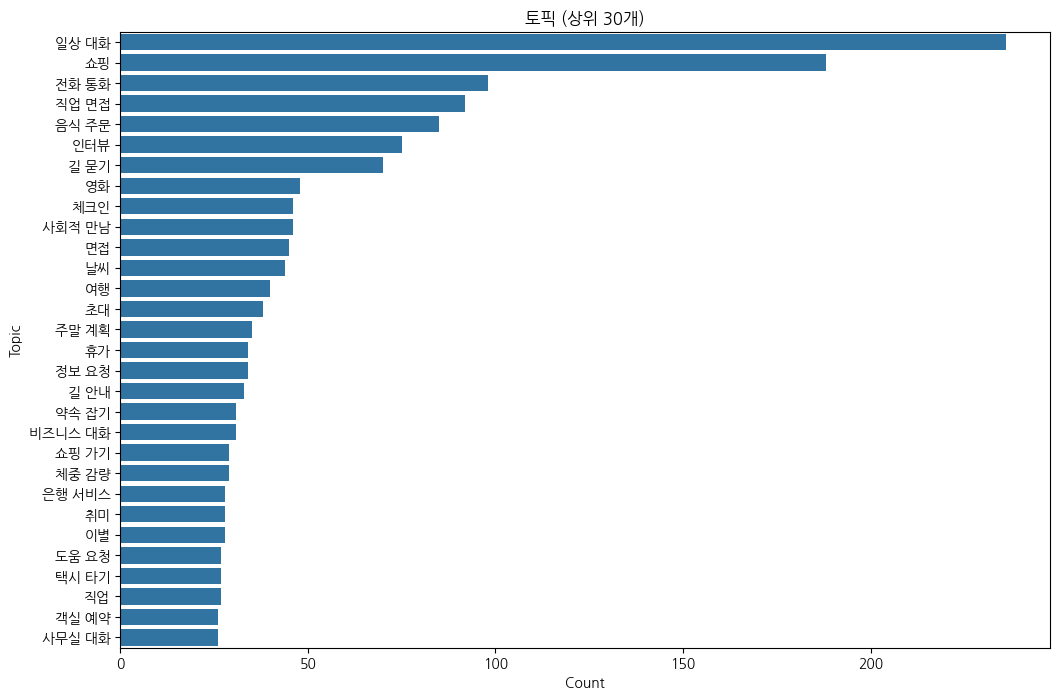

In [8]:
plt.figure(figsize=(12, 8))
sns.barplot(data=gb.iloc[:30], x='count', y='topic')#, palette='Set2')
plt.title(f'토픽 (상위 30개)') # 토픽 전체 6527개
plt.xlabel('Count')
plt.ylabel('Topic')
plt.show()

## 특정 토픽별 대화 흐름

### 일상 대화, 쇼핑, 전화 통화, 직업 면접, 음식 주문, 인터뷰, 길 묻기

In [9]:
def specific_topic(df, topic_name, idx):
    """
    df : 데이터프레임 변수
    topic_name : 특정 토픽 이름
    idx : 확인하려는 개수
    """
    cond = df[df['topic'] == topic_name]
    a = cond['dialogue'].reset_index(drop=True)
    b = cond['summary'].reset_index(drop=True)
    # print(f'{topic_name}: {len(cond)}개')
    for i in range(0, idx):
        print(f'--- 대화 ---\n{a[i]}')
        print(f'--- 요약 ---\n{b[i]}\n')

In [10]:
specific_topic(train_df, '길 묻기', 5)

--- 대화 ---
#Person1#: 실례합니다, 크로스 베이커리 빌딩에 어떻게 가는지 알려주실 수 있나요?
#Person2#: 크로스 베이커리 빌딩요? 그럼요, 사실 당신은 반대 방향으로 가고 계시네요.
#Person1#: 오, 농담이시죠. 저는 동쪽으로 가고 있다고 생각했어요.
#Person2#: 아니요, 동쪽은 다른 방향이에요. 베이커리로 가려면 돌아서서 브로드웨이까지 3블록을 가야 해요. 브로드웨이에 도착하면 왼쪽으로 돌아서 그 길을 2블록 직진하면 왼쪽에 건물이 보일 거에요. 그건 우체국과 슈퍼마켓 사이에 있어요.
#Person1#: 알겠습니다, 한번 정리해볼게요, 먼저 돌아서서 브로드웨이까지 3블록, 그리고 왼쪽으로 돌아서 건물까지 2블록, 맞나요?
#Person2#: 네, 맞아요.
--- 요약 ---
#Person2#가 #Person1#에게 크로스 베이커리 빌딩으로 가는 방법을 알려줍니다.

--- 대화 ---
#Person1#: 실례합니다, 어떻게 하면 뱅크 오브 아메리카로 갈 수 있나요? 길을 모르겠어요.
#Person2#: 그럼, 슈퍼마켓이 보일 때까지 계속 직진하세요. 은행은 그 길 건너편에 있어요.
#Person1#: 여기서 멀리 떨어져 있나요?
#Person2#: 잠시만요. 음, 4블록 떨어져 있어요. 그렇게 멀지도 가깝지도 않아요.
#Person1#: 버스나 뭐 그런 걸 탈 수 있나요?
#Person2#: 104번 버스나 B-201번 스트리트카를 타실 수 있어요. 버스는 4정거장, 스트리트카는 3정거장이에요.
#Person1#: 그런데 스트리트카는 어디서 타나요?
#Person2#: 아, 정류장은 바로 저기, 서점 앞에 있어요. 보이세요?
#Person1#: 정말 감사합니다.
#Person2#: 천만에요.
--- 요약 ---
#Person1#은 #Person2#에게 뱅크 오브 아메리카로 가는 길을 물었다. #Person2#는 #Person1#에게 방향과 선택지를 알려준다. #Person1#은 스트리트카를 탈 것이다.

--- 대화 -

## max_length 설정 등을 위한 길이 확인

### 초기 확인

In [11]:
# kobart-summarization 기준으로 확인
dialogue_tokenizer = train_df['dialogue'].apply(lambda x: tokenizer(x))
summary_tokenizer = train_df['summary'].apply(lambda x: tokenizer(x))
topic_tokenizer = train_df['topic'].apply(lambda x: tokenizer(x))

dialogue_len = dialogue_tokenizer.apply(lambda x: len(x['input_ids']))
summary_len = summary_tokenizer.apply(lambda x: len(x['input_ids']))
topic_len = topic_tokenizer.apply(lambda x: len(x['input_ids']))

In [12]:
# description으로 대략적인 파악
temp = dialogue_len.describe().reset_index()
temp0 = summary_len.describe().reset_index()
temp1 = topic_len.describe().reset_index()

length_dsc = temp.merge(temp0, on='index').merge(temp1, on='index')
length_dsc

index      dialogue       summary         topic
0  count  12457.000000  12457.000000  12457.000000
1   mean    306.817532     59.795376      3.979770
2    std    153.280534     25.390713      1.977168
3    min     70.000000     14.000000      2.000000
4    25%    210.000000     42.000000      3.000000
5    50%    277.000000     55.000000      4.000000
6    75%    377.000000     72.000000      5.000000
7    max   1823.000000    319.000000     95.000000

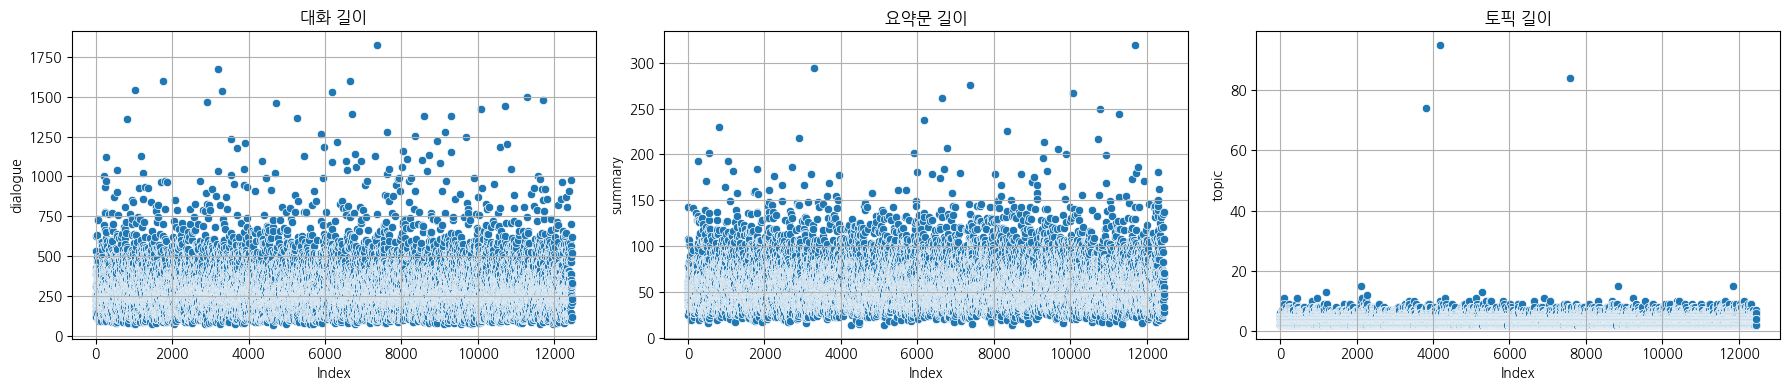

In [13]:
# scatter plot으로 분포 확인
plt.figure(figsize=(18, 4))

plt.subplot(1, 3, 1)
sns.scatterplot(data=dialogue_len.reset_index(), x=dialogue_len.index, y='dialogue')
plt.title('대화 길이')
plt.xlabel('Index')
plt.grid(True)

plt.subplot(1, 3, 2)
sns.scatterplot(data=summary_len.reset_index(), x=summary_len.index, y='summary')
plt.title('요약문 길이')
plt.xlabel('Index')
plt.grid(True)

plt.subplot(1, 3, 3)
sns.scatterplot(data=topic_len.reset_index(), x=topic_len.index, y='topic')
plt.title('토픽 길이')
plt.xlabel('Index')
plt.grid(True)

plt.tight_layout()
plt.show()

### 대화 길이보다 요약문 길이가 짧음

In [14]:
dia_len_list = dialogue_len.tolist()
sum_len_list = summary_len.tolist()
tpc_len_list = topic_len.tolist()

for idx in range(0, train_df.shape[0]):
    if dia_len_list[idx] <= sum_len_list[idx]:
        print(idx, end=' ')

### 대화 길이는 800 밑으로 대거 분포해있음

In [15]:
dia_len_800 = []
sum_len_125 = []
tpc_len_40 = []
for idx in range(0, train_df.shape[0]):
    if dia_len_list[idx] >= 800:
        dia_len_800.append(idx)
    if sum_len_list[idx] >= 125:
        sum_len_125.append(idx)
    if tpc_len_list[idx] >= 40:
        tpc_len_40.append(idx)

dia_800_df = train_df.loc[dia_len_800]
sum_125_df = train_df.loc[sum_len_125]
tpc_40_df = train_df.loc[tpc_len_40]

print(dia_800_df.shape[0], sum_125_df.shape[0], tpc_40_df.shape[0])

display(dia_800_df.head())
display(sum_125_df.head())
display(tpc_40_df.head())

151 271 3


fname                                           dialogue  \
210  train_210  #Person1#: 알버트와 저는 집을 꾸미기 위해 많은 물건이 필요해요. 하지만 ...   
250  train_250  #Person1#: 토네이도 경보가 내려졌어요. 제 어머니가 방금 라디오에서 들었다...   
258  train_258  #Person1#: 실례합니다. 여기 대학에서 중국어를 공부하시나요?\n#Perso...   
259  train_259  #Person1#: 오늘 어떻게 도와드릴까요, 앨리스?\n#Person2#: 장학금...   
477  train_477  #Person1#: 다음 학기에 어떤 과목을 들을지 결정했나요? \n#Person2...   

                                               summary     topic  
210  캐롤린은 #Person1#에게 집을 꾸미기 위한 쇼핑 장소를 물어본다. #Perso...     집 꾸미기  
250  #Person1#은 #Person2#에게 토네이도에 대한 세부 사항을 토네이도 경보...   토네이도 경보  
258  #Person2#는 중국어를 공부하지만 #Person2#의 글자는 매우 나쁘며, #...     언어 교환  
259  앨리스는 아시아계 미국인이며, 3학년 학생이고 GPA 3.92를 가지고 있기 때문에...  장학금 신청하기  
477  #Person2#는 4년 안에 학위를 마치기 위해 필요한 수업을 듣기를 원한다. #...     과목 선택

fname                                           dialogue  \
14    train_14  #Person1#: 어떤 종류의 음악을 듣는 것을 좋아하시나요?\n#Person2#...   
139  train_139  #Person1#: 바에서 너와 얘기하던 그 남자는 누구였어? 너에게 호감을 표시하...   
210  train_210  #Person1#: 알버트와 저는 집을 꾸미기 위해 많은 물건이 필요해요. 하지만 ...   
250  train_250  #Person1#: 토네이도 경보가 내려졌어요. 제 어머니가 방금 라디오에서 들었다...   
258  train_258  #Person1#: 실례합니다. 여기 대학에서 중국어를 공부하시나요?\n#Perso...   

                                               summary    topic  
14   #Person2#는 댄스 음악을 좋아하고, #Person1#은 클래식 음악을 선호합...       음악  
139  #Person2#는 그 남자와 크게 맞는 것 같지 않다고 느꼈다. #Person1#...       관계  
210  캐롤린은 #Person1#에게 집을 꾸미기 위한 쇼핑 장소를 물어본다. #Perso...    집 꾸미기  
250  #Person1#은 #Person2#에게 토네이도에 대한 세부 사항을 토네이도 경보...  토네이도 경보  
258  #Person2#는 중국어를 공부하지만 #Person2#의 글자는 매우 나쁘며, #...    언어 교환

fname                                           dialogue  \
3804  train_3804  #Person1#: 그린 씨, 미국 전역의 학교는 대체로 비슷한가요, 아니면 지역에...   
4181  train_4181  #Person1#: 오늘은 그 노부부의 금혼식이에요.\n#Person2#: 정말 오...   
7595  train_7595  #Person1#: 안녕, 나타샤, 어떻게 지내?\n#Person2#: 잘 지내. ...   

                                                summary  \
3804  그린 씨는 #Person1#에게 미국 대부분의 학생들은 공립학교에 다니며 특정 유형...   
4181         #Person1#과 #Person2#가 노부부의 금혼식에 대해 이야기합니다.   
7595  나타샤는 #Person1#에게 그녀의 가족이 그녀를 보러 왔다고 말한다. 그 후 그...   

                                                  topic  
3804  그린씨는 #Person1#에게 미국에서 대부분의 학생들이 공립학교에 다니며 특정 유...  
4181  오래가는 사랑                                       ...  
7595  나타샤는 #Person1#에게 그녀의 가족이 그녀를 보러 왔다고 말한다. 그 후 그...

In [16]:
def dia_sum_check(df):
    """
    df : 데이터프레임 변수
    """
    # idx_list = df['fname'].apply(lambda x: int(x.split('_')[1])).tolist() # fname 잘 못 되어 있음
    idx_list = df.reset_index()['index'].tolist()
    for idx in idx_list:
        print(f"--- 대화 ---\n{df['dialogue'].loc[idx]}")
        print(f"--- 요약 ---\n{df['summary'].loc[idx]}\n")

dia_sum_check(dia_800_df)

--- 대화 ---
#Person1#: 알버트와 저는 집을 꾸미기 위해 많은 물건이 필요해요. 하지만 어디가 최고의 쇼핑 장소인지 모르겠어요. 조언 좀 해주실 수 있나요?
#Person2#: 물론이죠, 캐롤린. 도와드릴 수 있어 기뻐요. 지금 당장 어떤 종류의 물건이 필요한가요?
#Person1#: 음, 가구는 대부분 이미 있어요. 주로 필요한 건 주방 용품, 욕실 액세서리, 청소 및 세탁 액세서리 같은 것들이에요. 그리고 알버트는 작은 사무실을 꾸미고 싶어해요
#Person2#: 알버트의 경우에는 사무용품 매장에 가는 게 좋을 것 같아요. 오피스 디포라는 아주 좋은 곳이 있어요. 그곳에는 그가 필요로 하는 모든 것이 있어요. 가격도 좋고, 매우 편리해요
#Person1#: 그걸 적어도 될까요?
#Person2#: 물론이죠, 오피스라고 쓰고 그 다음에 D - E - P - O - T라고 씁니다. 옐로우 페이지에 있어요.
#Person1#: 감사합니다.
#Person2#: 그리고 주방 용품에 대해서는, 아주 고품질의 것을 원하나요?
#Person1#: 어떤 말인지요?
#Person2#: 최고의 품질을 원하시는지, 아니면 좋은 가격을 원하시는지 말이에요.
#Person1#: 아마도 좋은 가격을 원할 것 같아요. 우리가 미국에 있을 기간이 약 1년 정도니까요.
#Person2#: 그럼 케이마트나 월마트에 가보시는 걸 추천드려요.
#Person1#: 그런 상점들이 무엇인가요?
#Person2#: 그들은 아주 큰 할인 백화점이에요. 즉, 그들의 가격은 아주 좋다는 뜻이죠. 그리고 주방이나 욕실에 필요한 모든 것을 찾을 수 있어요.
#Person1#: 심지어 식기도요?
#Person2#: 네, 모든 것이요. 그들은 가장 비싼 브랜드는 없지만, 그들의 품질은 보통 괜찮아요. 주요한 것은, 그들이 좋은 가격을 가지고 있고, 아주 편리하다는 것이죠.
#Person1#: 제 친구가 프라이스 클럽이라는 곳에 대해 얘기했어요. 그곳에 대해 알고 계신가요?
#Person2#: 저는 

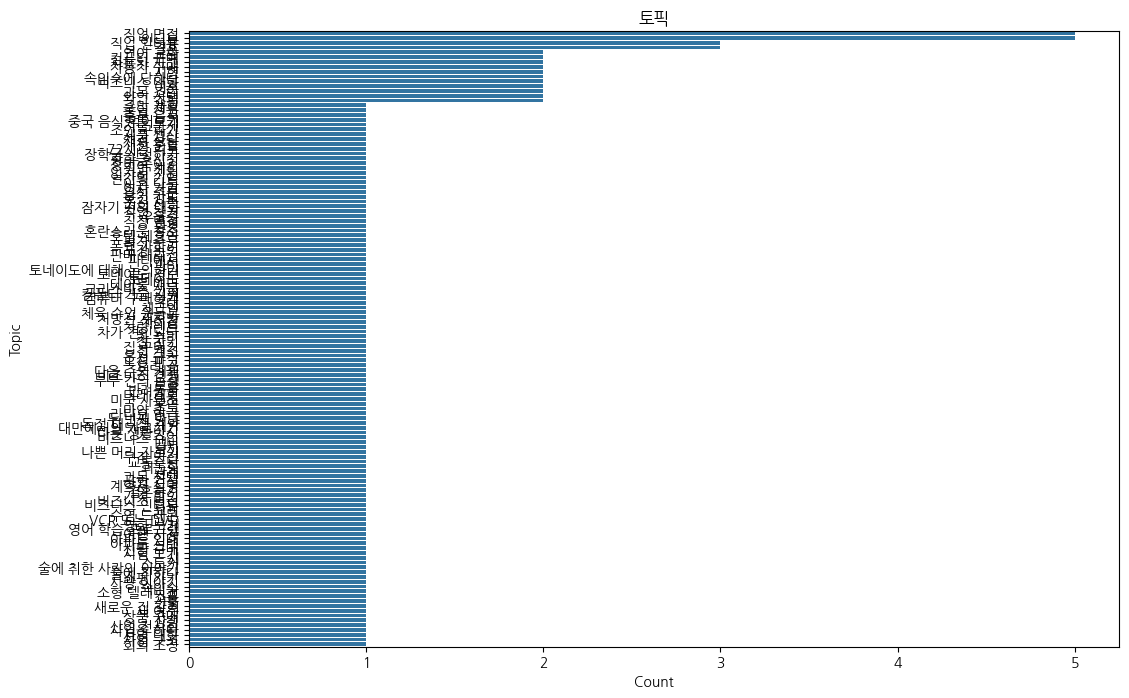

In [17]:
gb = dia_800_df.groupby('topic')['summary'].aggregate(['count']).sort_values(by='count', ascending=False).reset_index()
plt.figure(figsize=(12, 8))
sns.barplot(data=gb, x='count', y='topic')#, palette='Set2')
plt.title(f'토픽')
plt.xlabel('Count')
plt.ylabel('Topic')
plt.show()

### 요약문 길이는 125 밑으로 대거 분포해있음

In [18]:
dia_sum_check(sum_125_df)

--- 대화 ---
#Person1#: 어떤 종류의 음악을 듣는 것을 좋아하시나요?
#Person2#: 저는 빠른 비트와 활기찬 느낌의 음악, 예를 들면 댄스 음악을 좋아합니다. 당신도 알다시피, 매주 거의 디스코에 가요. 가끔은 너무 시끄러운 것 같기도 하지만요. 당신은 클래식 음악을 선호하시는 거죠?
#Person1#: 네, 맞아요. 저는 그것이 매우 편안하게 느껴져요. 힘든 하루를 보낸 후에는 종종 저녁에 모차르트나 바흐를 들어요.
#Person2#: 저도 사실 몇몇 클래식 음악을 좋아해요. 그것은 분명히 현대 댄스 음악보다 더 세련되었어요.
#Person1#: 클래식 음악은 두뇌에 좋다고 알려져 있어요. 연구 결과에 따르면, 그것은 두뇌를 더 활성화시킨다고 해요. 공부하면서 클래식 음악을 듣는 학생들이 더 잘하는 경향이 있어요.
#Person2#: 정말요? 저도 클래식 음악을 자주 들어야겠어요. 클래식 음악을 듣는 것이 스트레스를 줄이는 데 도움이 된다고 들었어요.
#Person1#: 네. 그래서 저는 저녁에 들어요. 요리하거나 다른 집안일을 하면서 보통 배경 음악으로 틀어놓아요.
#Person2#: 저도 몇 장의 클래식 음악 CD가 있어요. 당신의 방식을 따라서 두뇌력을 향상시켜야겠어요.
#Person1#: 인터넷에서도 많은 녹음을 찾을 수 있어요. 샘플을 듣고, 그것들이 마음에 들면 매우 저렴하게 구입할 수 있어요.
#Person2#: 좋은 생각이네요. 당신도 같은 방식으로 몇몇 음악을 찾아보세요. 당신이 좋아할 만한 것을 찾을 수 있을 거예요. 클래식 음악은 당신을 똑똑하게 만들 수 있지만, 댄스 음악은 당신을 더 활기차고 행복하게 만들 수 있을 거예요.
#Person1#: 그건 사실이죠. 활기찬 음악을 듣는 사람들이 활기찬 사람들이라는 명확한 증거가 있어요. 음악은 사람의 감정과 성격에 영향을 미칠 수 있어요.
--- 요약 ---
#Person2#는 댄스 음악을 좋아하고, #Person1#은 클래식 음악을 선호합니다. #Person1#은 두뇌를 

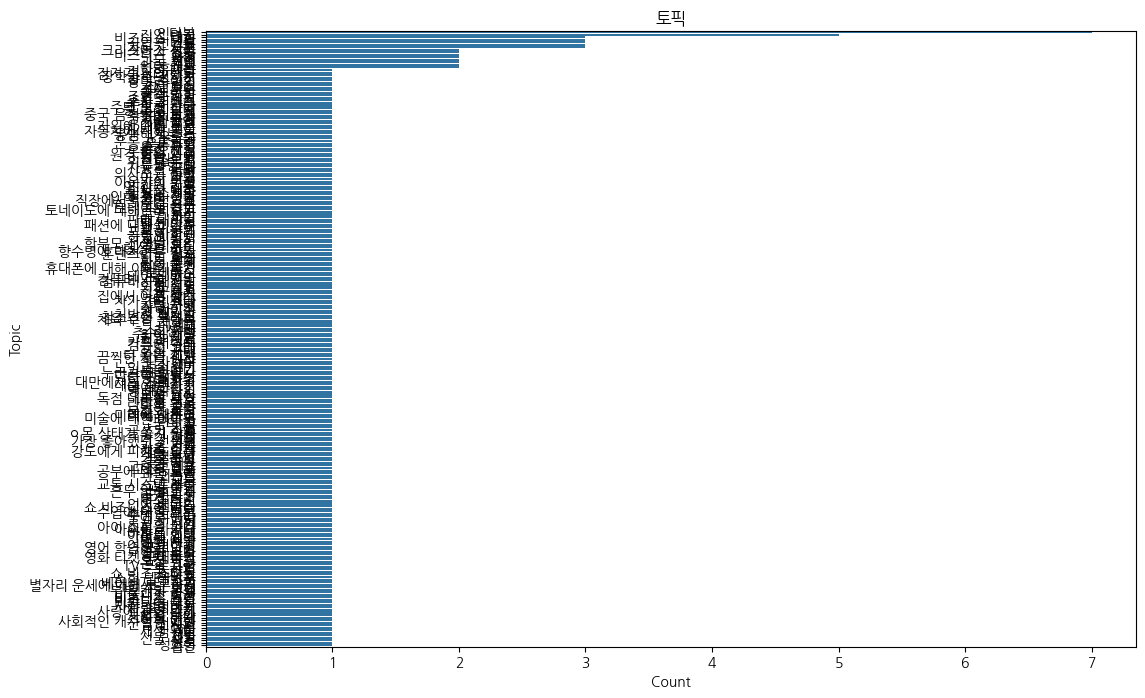

In [19]:
gb = sum_125_df.groupby('topic')['summary'].aggregate(['count']).sort_values(by='count', ascending=False).reset_index()
plt.figure(figsize=(12, 8))
sns.barplot(data=gb, x='count', y='topic')#, palette='Set2')
plt.title(f'토픽')
plt.xlabel('Count')
plt.ylabel('Topic')
plt.show()

### 토픽 길이는 대부분 20 이하인데, 40 이상인 토픽 3개가 존재함

In [20]:
dia_sum_check(tpc_40_df)

--- 대화 ---
#Person1#: 그린 씨, 미국 전역의 학교는 대체로 비슷한가요, 아니면 지역에 따라 다른가요?
#Person2#: 미국 전역의 공립학교 시스템은 대체로 일관되어 있습니다.
#Person1#: 미국의 대부분의 학생들은 사립학교에 다니나요, 아니면 공립학교에 다니나요?
#Person2#: 미국 대부분의 공립학교는 매우 좋고, 대다수의 학생들이 공립학교에 다닙니다.
#Person1#: 그럼 어떤 학생들이 사립학교에 다니나요?
#Person2#: 특별한 지도가 필요한 아이들. 부모님이 사립학교에 보낼 여유가 있는 아이들, 그리고 종교 교육을 시키고 싶어하는 부모님의 아이들입니다.
#Person1#: 그런데 공립학교는 어디든 괜찮은가요?
#Person2#: 아니요, 공립학교는 매우 다를 수 있습니다. 같은 도시라고 해도요.
#Person1#: 공립학교에 다니는 데 비용이 드나요? 누구는 다닐 수 있고 누구는 다닐 수 없는 제한이 있나요?
#Person2#: 미국의 공립학교는 모두에게 무료이며 학생에게 비용이 들지 않습니다. 대부분의 주에서는 교과서도 무료입니다. 색깔, 인종, 종교에 대한 제한은 없습니다. 공립학교에 다니고 싶어 하는 모든 학생이 다닐 수 있습니다.
--- 요약 ---
그린 씨는 #Person1#에게 미국 대부분의 학생들은 공립학교에 다니며 특정 유형의 학생들이 사립학교에 다닌다고 말합니다. 공립학교는 모두에게 무료이며 제한이 없지만 매우 다를 수 있다고 말합니다.

--- 대화 ---
#Person1#: 오늘은 그 노부부의 금혼식이에요.
#Person2#: 정말 오래가는 사랑 이야기군요.
#Person1#: 그래요. 두 분은 젊었을 때 영원히 함께하자고 약속했어요.
#Person2#: 그 약속을 지켰군요. 우리 사랑은 50년 동안 지속될까요?
#Person1#: 모르겠어요.
--- 요약 ---
#Person1#과 #Person2#가 노부부의 금혼식에 대해 이야기합니다.

--- 대화 ---
#Person1#: 안녕, 나타샤, 

In [21]:
for idx in tpc_40_df.reset_index()['index'].tolist():
    print(f"{idx}. {tpc_40_df['topic'][idx]}")

3804. 그린씨는 #Person1#에게 미국에서 대부분의 학생들이 공립학교에 다니며 특정 유형의 학생들이 사립학교에 다닌다고 말합니다. 공립학교는 모두에게 무료이며 제한이 없지만 매우 다를 수 있다고 말합니다.미국의 학교
4181. 오래가는 사랑                                                                                           
7595. 나타샤는 #Person1#에게 그녀의 가족이 그녀를 보러 왔다고 말한다. 그 후 그들은 각자의 가족에 대해 이야기한다. 나타샤의 직계 가족은 매우 크다. #Person1#의 가족은 작고, 12살인 동생이 있다.


### 좌우 공백 제거

In [22]:
dialogue_strip = train_df['dialogue'].apply(lambda x: x.strip())
summary_strip = train_df['summary'].apply(lambda x: x.strip())
topic_strip = train_df['topic'].apply(lambda x: x.strip())

dialogue_tokenizer_strip = dialogue_strip.apply(lambda x: tokenizer(x))
summary_tokenizer_strip = summary_strip.apply(lambda x: tokenizer(x))
topic_tokenizer_strip = topic_strip.apply(lambda x: tokenizer(x))

dialogue_strip_len = dialogue_tokenizer_strip.apply(lambda x: len(x['input_ids']))
summary_strip_len = summary_tokenizer_strip.apply(lambda x: len(x['input_ids']))
topic_strip_len = topic_tokenizer_strip.apply(lambda x: len(x['input_ids']))

index      dialogue       summary         topic
0  count  12457.000000  12457.000000  12457.000000
1   mean    306.783174     59.786947      3.967970
2    std    153.271384     25.392552      1.798545
3    min     70.000000     14.000000      2.000000
4    25%    210.000000     42.000000      3.000000
5    50%    277.000000     55.000000      4.000000
6    75%    377.000000     72.000000      5.000000
7    max   1823.000000    319.000000     84.000000

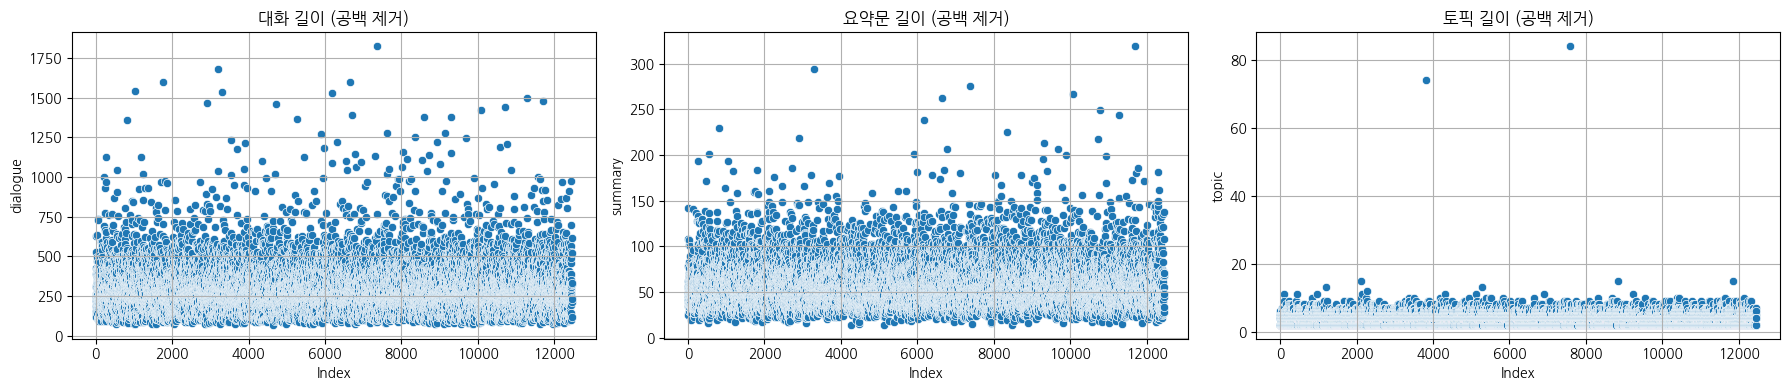

In [23]:
temp = dialogue_strip_len.describe().reset_index()
temp0 = summary_strip_len.describe().reset_index()
temp1 = topic_strip_len.describe().reset_index()

length_dsc = temp.merge(temp0, on='index').merge(temp1, on='index')
display(length_dsc)

plt.figure(figsize=(18, 4))

plt.subplot(1, 3, 1)
sns.scatterplot(data=dialogue_strip_len.reset_index(), x=dialogue_strip_len.index, y='dialogue')
plt.title('대화 길이 (공백 제거)')
plt.xlabel('Index')
plt.grid(True)

plt.subplot(1, 3, 2)
sns.scatterplot(data=summary_strip_len.reset_index(), x=summary_strip_len.index, y='summary')
plt.title('요약문 길이 (공백 제거)')
plt.xlabel('Index')
plt.grid(True)

plt.subplot(1, 3, 3)
sns.scatterplot(data=topic_strip_len.reset_index(), x=topic_strip_len.index, y='topic')
plt.title('토픽 길이 (공백 제거)')
plt.xlabel('Index')
plt.grid(True)

plt.tight_layout()
plt.show()

## 자음이나 모음만으로 구성된 경우 확인

In [24]:
moeum_list = ['ㅏ', 'ㅓ', 'ㅗ', 'ㅜ', 'ㅡ', 'ㅣ', 'ㅐ', 'ㅔ', 'ㅚ', 'ㅟ', 
              'ㅑ', 'ㅕ', 'ㅛ', 'ㅠ', 'ㅒ', 'ㅖ', 'ㅘ', 'ㅙ', 'ㅝ', 'ㅞ', 'ㅢ']
jaeum_list = ['ㄱ', 'ㄴ', 'ㄷ', 'ㄹ', 'ㅁ', 'ㅂ', 'ㅅ', 'ㅇ', 'ㅈ', 'ㅊ', 'ㅋ', 
              'ㅌ', 'ㅍ', 'ㅎ', 'ㄲ', 'ㄸ', 'ㅃ', 'ㅆ', 'ㅉ']

print('\n# 대화에서 모음만으로 구성된 경우')
print('---'*25)
for moeum in moeum_list:
    temp = train_df[train_df['dialogue'].apply(lambda x: x.find(moeum) != -1)]['dialogue']
    if len(temp) > 0:
        print(f'[{moeum}]')
        print(temp)
print('---'*25)

print('\n# 대화에서 자음만으로 구성된 경우')
print('---'*25)
for jaeum in jaeum_list:
    temp = train_df[train_df['dialogue'].apply(lambda x: x.find(jaeum) != -1)]['dialogue']
    if len(temp) > 0:
        print(f'[{jaeum}]')
        print(temp)
print('---'*25)

print('\n# 요약문에서 모음만으로 구성된 경우')
print('---'*25)
for moeum in moeum_list:
    temp = train_df[train_df['summary'].apply(lambda x: x.find(moeum) != -1)]['summary']
    if len(temp) > 0:
        print(f'[{moeum}]')
        print(temp)
print('---'*25)

print('\n# 요약문에서 자음만으로 구성된 경우')
print('---'*25)
for jaeum in jaeum_list:
    temp = train_df[train_df['summary'].apply(lambda x: x.find(jaeum) != -1)]['summary']
    if len(temp) > 0:
        print(f'[{jaeum}]')
        print(temp)
print('---'*25)


# 대화에서 모음만으로 구성된 경우
---------------------------------------------------------------------------
[ㅏ]
7201    #Person1#: 뭔지 맞춰볼래요? 나 좋은 소식이 있어요!\n#Person2#:...
Name: dialogue, dtype: object
[ㅣ]
6942    #Person1#: 여기가 제 사촌이 운영하는 코펠리니 가게예요. \n#Person...
Name: dialogue, dtype: object
---------------------------------------------------------------------------

# 대화에서 자음만으로 구성된 경우
---------------------------------------------------------------------------
[ㄷ]
12178    #Person1#: 도리스, 집에 와서 다행이야. 나 너무 무서워. 어떻게 해야 할...
Name: dialogue, dtype: object
[ㅇ]
5385    #Person1#: 제 영어 선생님이 저에게 오만과 편견을 읽으라고 하다니 믿을 수...
Name: dialogue, dtype: object
[ㅋ]
3154    #Person1#: 짐! 잘 지내? \n#Person2#: 찰리! 저게 너의 차야?...
5429    #Person1#: 너 남자친구 있어?\n#Person2#: 응, 전에 남자친구 있...
Name: dialogue, dtype: object
[ㅍ]
9677    #Person1#: 너 대신 퇴근 카드 찍어줄까, 로스? 난 이제 갈거야.\n#Pe...
Name: dialogue, dtype: object
---------------------------------------------------------------------------

# 요약문에서 모음만으로 구성된 경우
---------------------

In [25]:
print(train_df.loc[9677, 'dialogue'])

#Person1#: 너 대신 퇴근 카드 찍어줄까, 로스? 난 이제 갈거야.
#Person2#: 아니, 괜찮아. 나는 야근해야 해.
#Person1#: 하지만 오늘은 금요일이잖아. 금요일 저녁에 야근하려고 하지는 않겠지?
#Person2#: 음, 그래. 다음 주 월요일 회의를 위한 이 보고서를 끝내야 해. 톰이 널 데리러 오는 거야?
#Person1#: 아니. 우리 집에서 만날 거야. 그가 우리 가족을 그의 별장에서 주말을 보내도록 초대했어.
#Person2#: 좋네. 그의 별장은 어디에 있어?
#Person1#: 그 별장은 그의 것이 아니라 그의 아버지의 것이야. 플로리다 어딘가인 것 같아. 나도 확실하지 않아.
#Person2#: 가끔 너를 많이 부러워해. 톰은 좋은 사람이야.
#Person1#: 이제 그만. 너는 아직ㅍ알맞는 사람을 만나지 못했을 뿐이고, 너는 너무 많이 일하는 것 같아. 너는 어떻게 즐기고 삶을 즐기는 법을 배워야 해.
#Person2#: 알아, 하지만 나는 일광욕 중독자야.
#Person1#: 그래, 네 맘대로 해. 나는 이제 가야 해.
#Person2#: 좋은 주말 보내.
#Person1#: 너도. 아, 한 가지 말을 잊었어. 오늘 오후에 한 여자가 전화했어. 그녀가 너의 전 여자친구라고 했어. 그녀가 너에게 전화하라고 했어.
#Person2#: 그녀가 다른 얘기는 안했니?
#Person1#: 아니, 다른 건 없었어. 월요일에 봐.
#Person2#: 봐.


## 마스킹 확인

### 개인정보

In [26]:
def reg_masking(text):
    pattern = r'#\w+#'
    masked = re.findall(pattern, text)
    return masked

masked_train = train_df['dialogue'].apply(lambda x: str(set(reg_masking(x))))
for idx in range(0, train_df.shape[0]):
    print(masked_train[idx])

{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{

In [27]:
temp_df = masked_train.reset_index()
temp_df['dialogue'] = temp_df['dialogue'].apply(lambda x: set(eval(x)))
unique_dialogues = set().union(*temp_df['dialogue'])
print(unique_dialogues)

{'#Person4#', '#SSN#', '#Person6#', '#PhoneNumber#', '#Email#', '#Person5#', '#CarNumber#', '#Person7#', '#Person2#', '#Person1#', '#PassportNumber#', '#Person3#', '#Address#', '#CardNumber#', '#DateOfBirth#', '#Person#'}


### 사람

In [28]:
def reg_person(text):
    pattern = r'#\w+\d#'
    masked = re.findall(pattern, text)
    return masked

masked_person = train_df['dialogue'].apply(lambda x: str(set(reg_person(x))))
for idx in range(0, train_df.shape[0]):
    print(masked_person[idx])

{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{

In [29]:
temp_df = masked_person.reset_index()
temp_df['dialogue'] = temp_df['dialogue'].apply(lambda x: set(eval(x)))
unique_dialogues = set().union(*temp_df['dialogue'])
print(unique_dialogues)

{'#Person3#', '#Person4#', '#Person6#', '#Person5#', '#Person7#', '#Person2#', '#Person1#'}


## 데이터 전처리

In [30]:
# 좌우 공백 제거
train_df['dialogue'] = train_df['dialogue'].apply(lambda x: x.strip())
train_df['summary'] = train_df['summary'].apply(lambda x: x.strip())
train_df['topic'] = train_df['topic'].apply(lambda x: x.strip())

# 자음, 모음만으로 구성된 경우 적절한 값으로 대체
train_df['dialogue'] = train_df['dialogue'].apply(lambda x: x.replace('제ㅏ', '제가'))
train_df['dialogue'] = train_df['dialogue'].apply(lambda x: x.replace('척했ㄷ거든', '척했거든'))
train_df['dialogue'] = train_df['dialogue'].apply(lambda x: x.replace('배경ㅇ로', '배경으로'))
train_df['dialogue'] = train_df['dialogue'].apply(lambda x: x.replace('ㅋㅋ', '웃기다'))
train_df['dialogue'] = train_df['dialogue'].apply(lambda x: x.replace('아직ㅍ알맞는', '아직 알맞는'))
train_df['summary'] = train_df['summary'].apply(lambda x: x.replace('머라이어 ㅐ리', '머라이어 캐리'))

# special_tokens는 학습할 때 수정

In [31]:
train_df.to_csv('../../data/train_data-preprocessing.csv', index=False)

# Valid

## 토픽

In [32]:
gb = dev_df.groupby('topic')['summary'].aggregate(['count']).sort_values(by='count', ascending=False).reset_index()
gb

topic  count
0     직업 면접      9
1        쇼핑      7
2     일상 대화      4
3    레스토랑에서      4
4        지각      3
..      ...    ...
441  부모의 재량      1
442     부모님      1
443    벼룩시장      1
444     베이징      1
445      흥정      1

[446 rows x 2 columns]

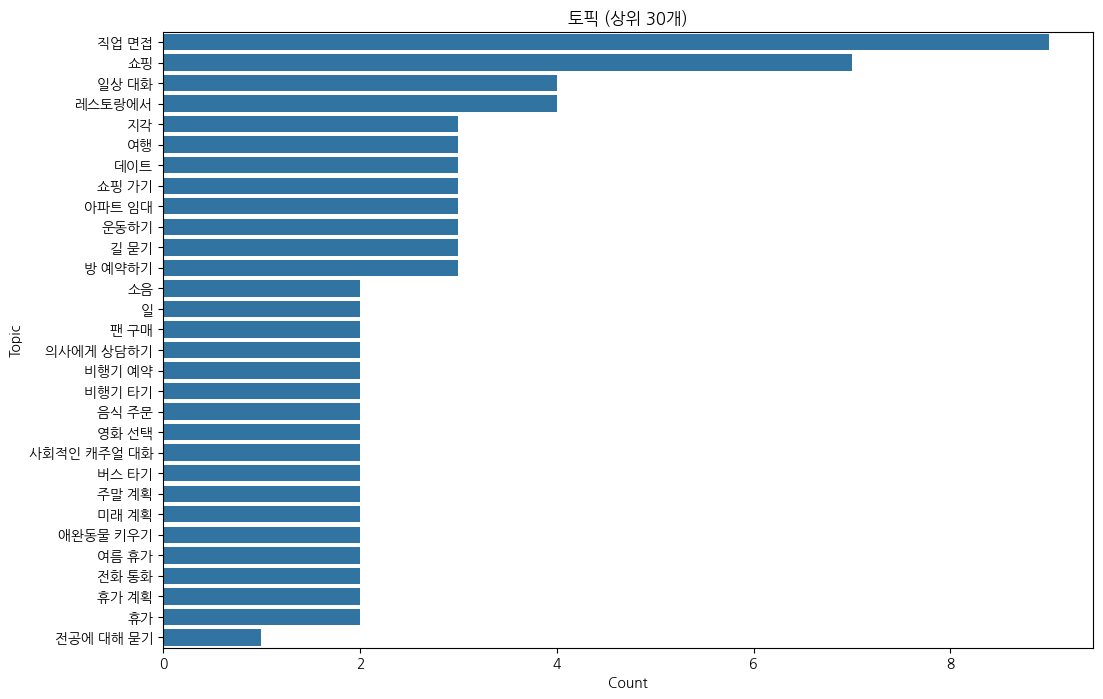

In [33]:
plt.figure(figsize=(12, 8))
sns.barplot(data=gb.iloc[:30], x='count', y='topic')#, palette='Set2')
plt.title(f'토픽 (상위 30개)') # 토픽 전체 6527개
plt.xlabel('Count')
plt.ylabel('Topic')
plt.show()

## 특정 토픽별 대화 흐름

### 직업 면접, 쇼핑, 일상 대화, 레스토랑에서

In [37]:
specific_topic(dev_df, '레스토랑에서', 4)

--- 대화 ---
#Person1#: 웨이터, 걸레 좀 가져다 주세요. 와인을 흘렸어요.
#Person2#: 제가 도와드리겠습니다.
#Person1#: 감사합니다. 종이 냅킨도 가져다 주세요.
#Person2#: 여기 있습니다.
#Person1#: 다음에는 좀 더 조심해야겠어요.
--- 요약 ---
#Person1#이 와인을 흘리고 걸레를 #Person2#에게 요청한다.

--- 대화 ---
#Person1#: 정말 운이 좋았어요. 마지막 2인석을 얻었는데---예약도 안 했었어요! 우리 뒤에 긴 줄 보셨나요?
#Person2#: 응, 오래 기다리지 않아서 다행이야. 배가 너무 고파!
#Person1#: 메뉴를 한 번 봐서 주문해봅시다. 나눠 먹을 에피타이저를 고를래요?
#Person2#: 삼모사와 파파돔 중에 어떤 게 더 좋아?
#Person1#: 여기 특별 메뉴 중 하나가 삼모사라고 들었어요.
#Person2#: 그럼 그걸로 한 접시 주문하자.
#Person1#: 좋아요. 메인 코스로 뭘 드실 건가요?
#Person2#: 나는 달을 먹을 것 같아.
#Person1#: 달에는 뭐가 들어있나요?
#Person2#: 치킨피스와 야채가 매운 카레 소스와 함께 들어있고, 밥이 함께 나와.
#Person1#: 맛있겠네요. 케밥도 같이 나눠 먹을래요?
#Person2#: 좋아. 양고기 케밥 어때?
#Person1#: 그게 제가 가장 좋아하는 거예요. 와인이나 맥주 드실래요?
#Person2#: 나는 맥주를 마실 거야.
#Person1#: 알겠어, 점원을 부를까요?
#Person2#: 그건 별로인 것 같아. 그녀가 다시 돌아올 때까지 기다리자.
#Person1#: 맞아요. 그게 좀 무례하게 보일 수도 있겠네요. 당신이 함께 있어서 다행이네요!
#Person2#: 나 없이 어떻게 살았을까?
--- 요약 ---
#Person1#과 #Person2#는 인기있는 레스토랑에서 무엇을 먹을지 논의하고 있으며, 점원이 다시 돌아올 때까지 주문하기로 결정했습니다.

--- 대화 ---

## max_length 설정 등을 위한 길이 확인

### 초기 확인

In [38]:
# kobart-summarization 기준으로 확인
dialogue_tokenizer = dev_df['dialogue'].apply(lambda x: tokenizer(x))
summary_tokenizer = dev_df['summary'].apply(lambda x: tokenizer(x))
topic_tokenizer = dev_df['topic'].apply(lambda x: tokenizer(x))

dialogue_len = dialogue_tokenizer.apply(lambda x: len(x['input_ids']))
summary_len = summary_tokenizer.apply(lambda x: len(x['input_ids']))
topic_len = topic_tokenizer.apply(lambda x: len(x['input_ids']))

In [39]:
# description으로 대략적인 파악
temp = dialogue_len.describe().reset_index()
temp0 = summary_len.describe().reset_index()
temp1 = topic_len.describe().reset_index()

length_dsc = temp.merge(temp0, on='index').merge(temp1, on='index')
length_dsc

index     dialogue     summary       topic
0  count   499.000000  499.000000  499.000000
1   mean   303.336673   56.008016    4.094188
2    std   144.728700   24.250283    1.497369
3    min    93.000000   16.000000    2.000000
4    25%   208.000000   38.000000    3.000000
5    50%   275.000000   51.000000    4.000000
6    75%   370.000000   67.000000    5.000000
7    max  1099.000000  180.000000   12.000000

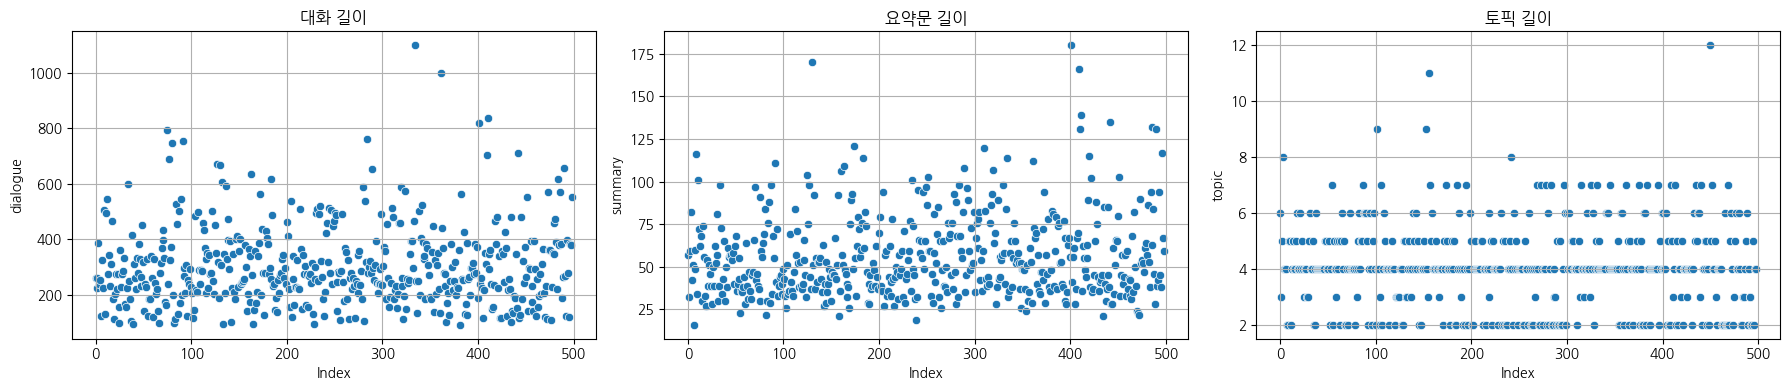

In [40]:
# scatter plot으로 분포 확인
plt.figure(figsize=(18, 4))

plt.subplot(1, 3, 1)
sns.scatterplot(data=dialogue_len.reset_index(), x=dialogue_len.index, y='dialogue')
plt.title('대화 길이')
plt.xlabel('Index')
plt.grid(True)

plt.subplot(1, 3, 2)
sns.scatterplot(data=summary_len.reset_index(), x=summary_len.index, y='summary')
plt.title('요약문 길이')
plt.xlabel('Index')
plt.grid(True)

plt.subplot(1, 3, 3)
sns.scatterplot(data=topic_len.reset_index(), x=topic_len.index, y='topic')
plt.title('토픽 길이')
plt.xlabel('Index')
plt.grid(True)

plt.tight_layout()
plt.show()

### 대화 길이보다 요약문 길이가 짧음

In [41]:
dia_len_list = dialogue_len.tolist()
sum_len_list = summary_len.tolist()
tpc_len_list = topic_len.tolist()

for idx in range(0, dev_df.shape[0]):
    if dia_len_list[idx] <= sum_len_list[idx]:
        print(idx, end=' ')

### 대화 길이는 600 밑으로 대거 분포해있음

In [42]:
dia_len_600 = []
sum_len_100 = []
tpc_len_8 = []
for idx in range(0, dev_df.shape[0]):
    if dia_len_list[idx] >= 600:
        dia_len_600.append(idx)
    if sum_len_list[idx] >= 100:
        sum_len_100.append(idx)
    if tpc_len_list[idx] >= 8:
        tpc_len_8.append(idx)

dia_600_df = dev_df.loc[dia_len_600]
sum_100_df = dev_df.loc[sum_len_100]
tpc_8_df = dev_df.loc[tpc_len_8]

print(dia_600_df.shape[0], sum_100_df.shape[0], tpc_8_df.shape[0])

display(dia_600_df.head())
display(sum_100_df.head())
display(tpc_8_df.head())

19 27 6


fname                                           dialogue  \
75    dev_75  #Person1#: 어디를 가는지 좀 보면서 가지 왜 그래요?\n#Person2#:...   
77    dev_77  #Person1#: 안녕, 케빈!\n#Person2#: 안녕, 로라, 오랜만이네! ...   
80    dev_80  #Person1#: 네, 저 도둑질을 신고하려고 합니다.\n#Person2#: 알겠...   
91    dev_91  #Person1#: 들어봐, 카렌, 너의 도움이 필요해. 아직 여기 아는 사람이 없...   
127  dev_127  #Person1#: 이제 결제 조건을 정했습니다. 9월 동안에 배송이 가능한가요?\...   

                                               summary     topic  
75   자동차 사고가 발생했는데, 이는 #Person1#이 #Person2#의 차 앞에 갑...    자동차 사고  
77   로라와 케빈은 오랜만에 만나 서로의 최근 소식을 공유한다. 로라는 직장 승진과 월급...     소식 공유  
80   #Person1#이 경찰에게 도둑질을 신고합니다. #Person1#은 도둑의 모습을...       도둑질  
91   #Person1#은 카렌에게 도움을 청해 2~3일 동안 돌봐줄 성숙한 베이비시터를 ...  베이비시터 찾기  
127  #Person1#은 #Person2#가 제공할 수 있는 가장 빠른 배송이 너무 늦다...     배송 시간

fname                                           dialogue  \
9      dev_9  #Person1#: 인터넷에서 빌 게이츠의 집을 본 적이 있나요?\n#Person2...   
11    dev_11  #Person1#: 여기 홍콩에는 어디에나 광고가 있어요. 모든 네온 사인들로 인해...   
91    dev_91  #Person1#: 들어봐, 카렌, 너의 도움이 필요해. 아직 여기 아는 사람이 없...   
125  dev_125  #Person1#: 마이클, 새 집으로 이사하셨나요?\n#Person2#: 사실 어...   
130  dev_130  #Person1#: 안녕하세요, 어떻게 도와드릴까요?\n#Person2#: 제 금목...   

                                               summary     topic  
9    #Person1#과 #Person2#는 빌 게이츠의 집에 대해 이야기한다. #Per...      꿈의 집  
11   #Person1#과 #Person2#는 홍콩의 광고에 대해 이야기한다. #Perso...        광고  
91   #Person1#은 카렌에게 도움을 청해 2~3일 동안 돌봐줄 성숙한 베이비시터를 ...  베이비시터 찾기  
125  #Person1#과 #Person2#는 #Person2#의 새 집에 대해 이야기합니...       새 집  
130  #Person2#는 그녀의 목걸이가 도난당했다고 주장합니다. #Person1#는 #...   분실된 목걸이

fname                                           dialogue  \
3      dev_3  #Person1#: UFO를 믿으세요?\n#Person2#: 물론이죠, 그들은 저기...   
101  dev_101  #Person1#: 그 당나라 스타일의 중국 드레스가 너무 아름답네요. 제게 보여주...   
153  dev_153  #Person1#: 이 아파트를 빌릴 수 있을 것 같아요.\n#Person2#: 잘...   
156  dev_156  #Person1#: 너 여기 얼마나 있었어? 이제 4개월 됐지?\n#Person2#...   
242  dev_242  #Person1#: 너 유로 2012 축구 토너먼트 보고 있었어?\n#Person2...   

                                               summary            topic  
3    #Person2#는 UFO를 믿고 꿈에서 그들을 볼 수 있다고 말한다. #Perso...         UFO와 외계인  
101  #Person1#은 상점에서 조금 꽉 느껴지는 중국 드레스를 입어보고 #Person...  당나라 스타일의 중국 드레스  
153  #Person1#은 #Person2#에게서 아파트를 빌리려고 합니다. 그들은 임대료...     임대료에 대해 논의하기  
156  #Person2#는 여자친구가 중국어로 판매원과 흥정하는 것이 말싸움처럼 들렸다. ...   중국인의 흥정에 대한 논의  
242  #Person1#과 #Person2#는 미국식 축구와 축구의 차이점에 대해 이야기한...       미국식 축구와 축구

In [43]:
dia_sum_check(dia_600_df)

--- 대화 ---
#Person1#: 어디를 가는지 좀 보면서 가지 왜 그래요?
#Person2#: 저요? 당신이 제 앞에 갑자기 나타난 거잖아요!
#Person1#: 충분히 제가 나갈 공간이 있었어요. 굳이 그 차선에 계속 있을 필요는 없었어요.
#Person2#: 이거 들어봐요. 제가 그 차선에 계속 있을 권리가 있었어요. 당신이 제가 지나가기를 기다렸다가 나가야 했어요. 게다가, 차선을 바꿀 시간도 주지 않았잖아요. 갑자기--쾅--당신이 제 앞에 나타나 있더군요.
#Person1#: 제 팔이 부러진 것 같아요.
#Person2#: 팔이 아프다니 미안하네요, 하지만 당연한 결과예요. 운전을 어떻게 해야 하는지 배워야 해요. 죽지 않아서 다행이에요. 저도 살아남아서 다행이죠.
#Person1#: 들어봐요, 경찰이 오기를 기다리는 게 좋겠어요. 그럼 이 사고의 책임이 누구에게 있는지 결정할 수 있겠죠.
#Person2#: 저는 괜찮아요. 도로 규칙을 알고 있으니까요. 걱정하지 않아요.
#Person1#: 제 차에 휴대폰이 있어요. 아마 승객석 바닥에 떨어져 있을 거예요. 제 휴대폰 좀 가져다 주시면 제가 경찰에게 전화할 수 있을 거예요.
#Person2#: 알겠어요.
#Person1#: 작동이 안 돼요. 망가진 것 같아요. 병원에 가야 해요. 당신이 저를 데려다 주어야 해요.
#Person2#: 그래요? 먼저 경찰에게 보고하는 게 좋을 것 같아요. 그런 다음에 병원에 가면 되죠.
#Person1#: 젠장! 제가 다치고 있는데요. 경찰이 올 때까지 하루 종일 기다릴 수도 있어요.
#Person2#: 그럼 기다려야죠. 경찰이 올 때까지 제 차는 움직이지 않을 거예요. 저기 있는 집 중 하나로 가서 전화를 해야겠어요. 걱정 마세요. 병원에 제 시간에 갈 수 있을 거예요.
#Person1#: 정말 아파요.
#Person2#: 그럴 수도 있겠네요. 하지만 방금처럼 운전하면 약간의 신체적 고통에 익숙해져야 해요. 알겠죠?
#Person1#: 당신이랑 상관없어요. 사고는

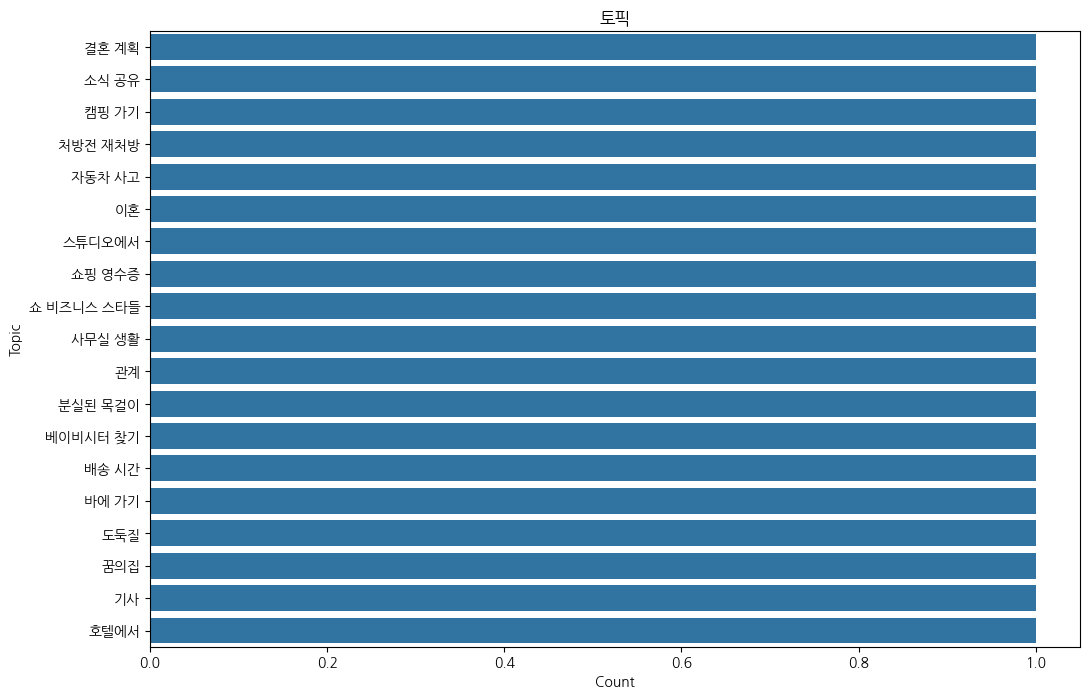

In [44]:
gb = dia_600_df.groupby('topic')['summary'].aggregate(['count']).sort_values(by='count', ascending=False).reset_index()
plt.figure(figsize=(12, 8))
sns.barplot(data=gb, x='count', y='topic')#, palette='Set2')
plt.title(f'토픽')
plt.xlabel('Count')
plt.ylabel('Topic')
plt.show()

### 요약문 길이는 100 밑으로 대거 분포해있음

In [45]:
dia_sum_check(sum_100_df)

--- 대화 ---
#Person1#: 인터넷에서 빌 게이츠의 집을 본 적이 있나요?
#Person2#: 아니요. 어떤 모습인가요?
#Person1#: 그 집에는 독립된 도서관, 극장, 수영장, 그리고 게스트 하우스가 있어요. 집 자체에는 컴퓨터로 연결된 10개의 다른 방이 있어서 각 방에서 일을 처리할 수 있어요.
#Person2#: 그곳에서 살고 싶나요?
#Person1#: 그의 집은 환상적이지만, 저는 거기에서 살고 싶지 않아요. 집 안의 모든 방을 청소하기 위해 한 두 명의 사람을 고용해야 하고, 또 몇 명의 사람들이 정원을 돌봐야 하거든요.
#Person2#: 그럼 당신의 꿈의 집은 어떤 모습인가요?
#Person1#: 제 꿈의 집은 사실 영국의 한 조용한 마을에 있는 작은 오두막이에요.
#Person2#: 오래된 오두막을 사거나 새로 짓고 싶나요?
#Person1#: 오래된 집들은 개성이 있어서 좋아요. 그것이 중요하다고 생각해요.
#Person2#: 그래서 당신이 중고 옷을 입는 이유도 개성이 있기 때문인가요?
#Person1#: 아니요, 그건 그냥 제가 새 옷을 계속 사기에는 돈이 부족하기 때문이에요!
#Person2#: 알겠어요. 오래된 집에서 살면, 현대적인 방식으로 꾸미고 싶나요?
#Person1#: 아니요, 저는 꼭 원래 상태로 복원하려고 노력할 거예요. 저는 역사 속의 다른 시기에 살아보는 것이 어떤 느낌일지 상상하는 것을 좋아해요.
--- 요약 ---
#Person1#과 #Person2#는 빌 게이츠의 집에 대해 이야기한다. #Person1#은 그 집이 환상적이라고 생각하지만 거기에서 살고 싶지는 않다. #Person2#는 #Person1#의 꿈의 집에 대해 묻는다. #Person1#은 그것의 개성 때문에 작고 오래된 오두막에서 살고 싶어한다.

--- 대화 ---
#Person1#: 여기 홍콩에는 어디에나 광고가 있어요. 모든 네온 사인들로 인해 밤에 도시가 너무 밝아요.
#Person2#: 저는 좋아요. 도시가 살아있는 것 같아요.

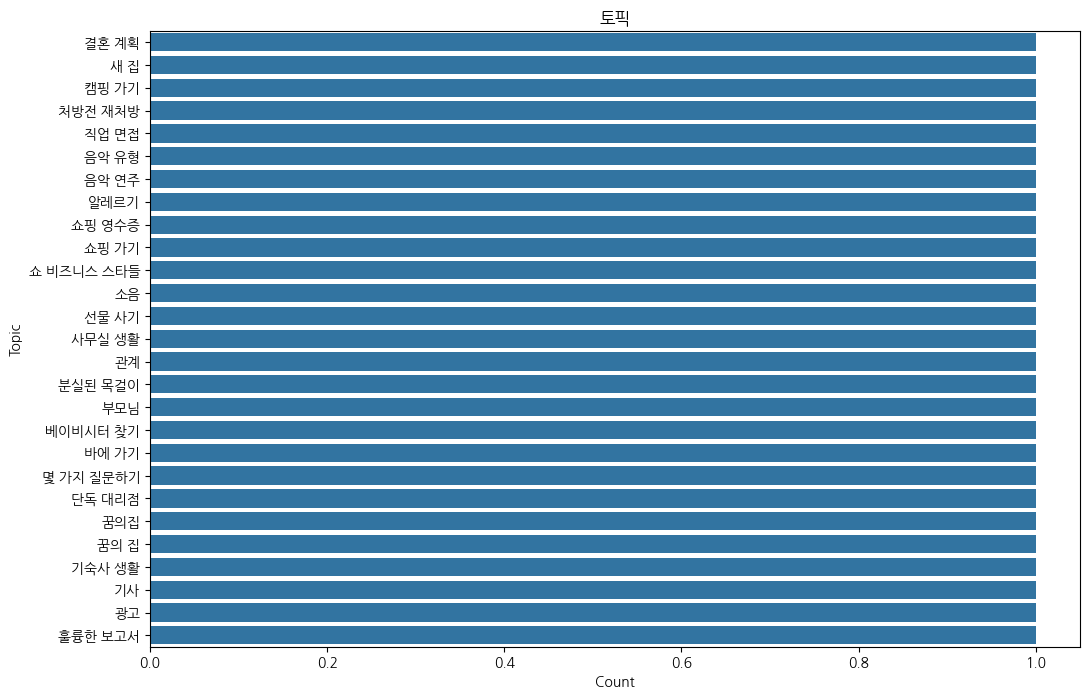

In [46]:
gb = sum_100_df.groupby('topic')['summary'].aggregate(['count']).sort_values(by='count', ascending=False).reset_index()
plt.figure(figsize=(12, 8))
sns.barplot(data=gb, x='count', y='topic')#, palette='Set2')
plt.title(f'토픽')
plt.xlabel('Count')
plt.ylabel('Topic')
plt.show()

### 토픽 길이는 대부분 8 이하인데, 7 이상인 토픽 6개가 존재함

In [47]:
dia_sum_check(tpc_8_df)

--- 대화 ---
#Person1#: UFO를 믿으세요?
#Person2#: 물론이죠, 그들은 저기 어딘가에 있어요.
#Person1#: 하지만 저는 그들을 본 적이 없어요.
#Person2#: 당신은 바본가요? 그들이 UFO라고 불리우는 이유가 모두가 볼 수 있는 것이 아니기 때문이에요.
#Person1#: 그러니까 당신은 그들을 볼 수 있다는 거죠.
#Person2#: 맞아요. 저는 꿈에서 그들을 볼 수 있어요.
#Person1#: 그들이 지구에 오나요?
#Person2#: 아니요. 그들의 임무는 외계인들을 우주에서 여기로 보내는 것이에요.
#Person1#: 우주에선 온 외계인들이라고요? 그들과 대화하나요? 그들은 어떻게 생겼나요?
#Person2#: 좋아요, 좋아요, 하나씩이요! 그들은 로봇처럼 생겼지만 말할 수 있어요. 그들의 임무는 인간과 친구가 되는 것이에요.
#Person1#: 그러니까 당신이 그들과 대화한다는 거죠? 어떤 언어로요?
#Person2#: 당연히 영어로요, 그들도 화성에서 영어를 배우거든요.
#Person1#: 와. 정말 멋져 보이네요!
--- 요약 ---
#Person2#는 UFO를 믿고 꿈에서 그들을 볼 수 있다고 말한다. #Person1#는 #Person2#에게 UFO와 꿈 속의 외계인에 대해 묻고, #Person2#의 꿈을 멋지다고 느낀다.

--- 대화 ---
#Person1#: 그 당나라 스타일의 중국 드레스가 너무 아름답네요. 제게 보여주실 수 있나요?
#Person2#: 물론이죠. 여기 있습니다.
#Person1#: 제가 입어봐도 될까요?
#Person2#: 네, 해보세요. 피팅룸은 저쪽에 있습니다.
#Person1#: 허리 부분이 조금 꽉 느껴지네요. 더 큰 사이즈는 없나요?
#Person2#: 죄송합니다. 이 색상은 품절이네요. 당신의 사이즈에 맞는 녹색이 있습니다. 이 녹색은 어떠신가요?
#Person1#: 좋아요. 이건 얼마인가요?
#Person2#: 486 위안입니다.
--- 요약 ---
#Person1#은

In [48]:
for idx in tpc_8_df.reset_index()['index'].tolist():
    print(f"{idx}. {tpc_8_df['topic'][idx]}")

3. UFO와 외계인
101. 당나라 스타일의 중국 드레스
153. 임대료에 대해 논의하기
156. 중국인의 흥정에 대한 논의
242. 미국식 축구와 축구
450. 호텔 내 즐길 수 있는 장소


### 좌우 공백 제거

In [49]:
dialogue_strip = dev_df['dialogue'].apply(lambda x: x.strip())
summary_strip = dev_df['summary'].apply(lambda x: x.strip())
topic_strip = dev_df['topic'].apply(lambda x: x.strip())

dialogue_tokenizer_strip = dialogue_strip.apply(lambda x: tokenizer(x))
summary_tokenizer_strip = summary_strip.apply(lambda x: tokenizer(x))
topic_tokenizer_strip = topic_strip.apply(lambda x: tokenizer(x))

dialogue_strip_len = dialogue_tokenizer_strip.apply(lambda x: len(x['input_ids']))
summary_strip_len = summary_tokenizer_strip.apply(lambda x: len(x['input_ids']))
topic_strip_len = topic_tokenizer_strip.apply(lambda x: len(x['input_ids']))

index     dialogue     summary       topic
0  count   499.000000  499.000000  499.000000
1   mean   303.284569   56.000000    4.094188
2    std   144.703364   24.255915    1.497369
3    min    93.000000   15.000000    2.000000
4    25%   208.000000   38.000000    3.000000
5    50%   275.000000   51.000000    4.000000
6    75%   370.000000   67.000000    5.000000
7    max  1099.000000  180.000000   12.000000

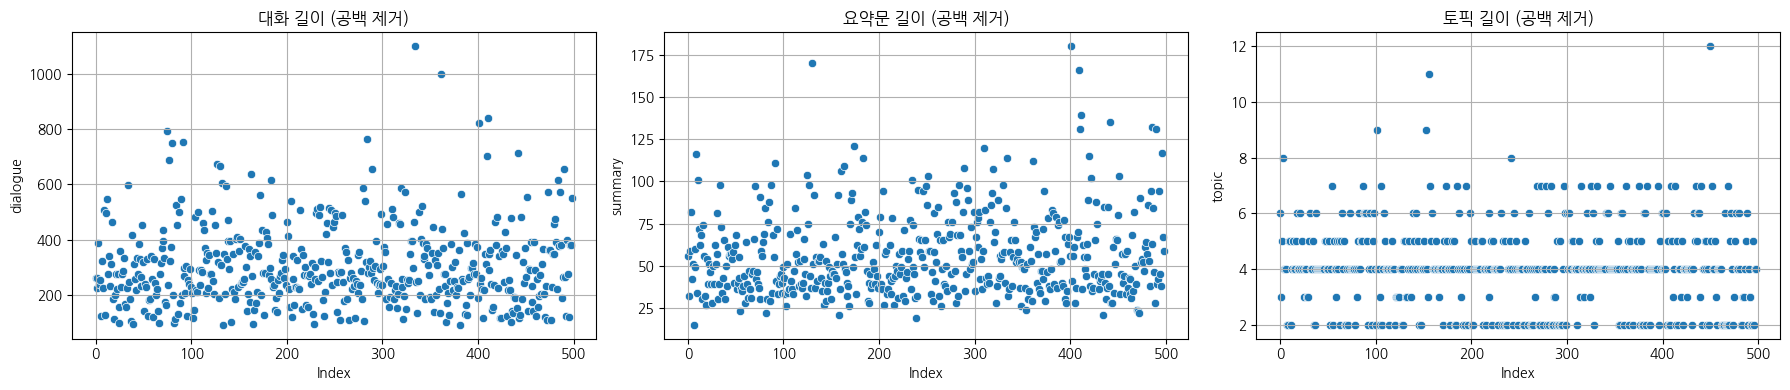

In [50]:
temp = dialogue_strip_len.describe().reset_index()
temp0 = summary_strip_len.describe().reset_index()
temp1 = topic_strip_len.describe().reset_index()

length_dsc = temp.merge(temp0, on='index').merge(temp1, on='index')
display(length_dsc)

plt.figure(figsize=(18, 4))

plt.subplot(1, 3, 1)
sns.scatterplot(data=dialogue_strip_len.reset_index(), x=dialogue_strip_len.index, y='dialogue')
plt.title('대화 길이 (공백 제거)')
plt.xlabel('Index')
plt.grid(True)

plt.subplot(1, 3, 2)
sns.scatterplot(data=summary_strip_len.reset_index(), x=summary_strip_len.index, y='summary')
plt.title('요약문 길이 (공백 제거)')
plt.xlabel('Index')
plt.grid(True)

plt.subplot(1, 3, 3)
sns.scatterplot(data=topic_strip_len.reset_index(), x=topic_strip_len.index, y='topic')
plt.title('토픽 길이 (공백 제거)')
plt.xlabel('Index')
plt.grid(True)

plt.tight_layout()
plt.show()

## 자음이나 모음만으로 구성된 경우 확인

In [51]:
moeum_list = ['ㅏ', 'ㅓ', 'ㅗ', 'ㅜ', 'ㅡ', 'ㅣ', 'ㅐ', 'ㅔ', 'ㅚ', 'ㅟ', 
              'ㅑ', 'ㅕ', 'ㅛ', 'ㅠ', 'ㅒ', 'ㅖ', 'ㅘ', 'ㅙ', 'ㅝ', 'ㅞ', 'ㅢ']
jaeum_list = ['ㄱ', 'ㄴ', 'ㄷ', 'ㄹ', 'ㅁ', 'ㅂ', 'ㅅ', 'ㅇ', 'ㅈ', 'ㅊ', 'ㅋ', 
              'ㅌ', 'ㅍ', 'ㅎ', 'ㄲ', 'ㄸ', 'ㅃ', 'ㅆ', 'ㅉ']

print('\n# 대화에서 모음만으로 구성된 경우')
print('---'*25)
for moeum in moeum_list:
    temp = dev_df[dev_df['dialogue'].apply(lambda x: x.find(moeum) != -1)]['dialogue']
    if len(temp) > 0:
        print(f'[{moeum}]')
        print(temp)
print('---'*25)

print('\n# 대화에서 자음만으로 구성된 경우')
print('---'*25)
for jaeum in jaeum_list:
    temp = dev_df[dev_df['dialogue'].apply(lambda x: x.find(jaeum) != -1)]['dialogue']
    if len(temp) > 0:
        print(f'[{jaeum}]')
        print(temp)
print('---'*25)

print('\n# 요약문에서 모음만으로 구성된 경우')
print('---'*25)
for moeum in moeum_list:
    temp = dev_df[dev_df['summary'].apply(lambda x: x.find(moeum) != -1)]['summary']
    if len(temp) > 0:
        print(f'[{moeum}]')
        print(temp)
print('---'*25)

print('\n# 요약문에서 자음만으로 구성된 경우')
print('---'*25)
for jaeum in jaeum_list:
    temp = dev_df[dev_df['summary'].apply(lambda x: x.find(jaeum) != -1)]['summary']
    if len(temp) > 0:
        print(f'[{jaeum}]')
        print(temp)
print('---'*25)


# 대화에서 모음만으로 구성된 경우
---------------------------------------------------------------------------
---------------------------------------------------------------------------

# 대화에서 자음만으로 구성된 경우
---------------------------------------------------------------------------
---------------------------------------------------------------------------

# 요약문에서 모음만으로 구성된 경우
---------------------------------------------------------------------------
---------------------------------------------------------------------------

# 요약문에서 자음만으로 구성된 경우
---------------------------------------------------------------------------
---------------------------------------------------------------------------


## 마스킹 확인

### 개인정보

In [52]:
masked_dev = dev_df['dialogue'].apply(lambda x: str(set(reg_masking(x))))
for idx in range(0, dev_df.shape[0]):
    print(masked_dev[idx])

{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{

In [53]:
temp_df = masked_dev.reset_index()
temp_df['dialogue'] = temp_df['dialogue'].apply(lambda x: set(eval(x)))
unique_dialogues = set().union(*temp_df['dialogue'])
print(unique_dialogues)

{'#Person3#', '#Person4#', '#PhoneNumber#', '#Address#', '#Person2#', '#Person1#', '#DateOfBirth#'}


### 사람

In [55]:
masked_person = dev_df['dialogue'].apply(lambda x: str(set(reg_person(x))))
for idx in range(0, dev_df.shape[0]):
    print(masked_person[idx])

{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{'#Person1#', '#Person2#'}
{

In [56]:
temp_df = masked_person.reset_index()
temp_df['dialogue'] = temp_df['dialogue'].apply(lambda x: set(eval(x)))
unique_dialogues = set().union(*temp_df['dialogue'])
print(unique_dialogues)

{'#Person3#', '#Person4#', '#Person2#', '#Person1#'}


## 데이터 전처리

In [57]:
# 좌우 공백 제거
dev_df['dialogue'] = dev_df['dialogue'].apply(lambda x: x.strip())
dev_df['summary'] = dev_df['summary'].apply(lambda x: x.strip())
dev_df['topic'] = dev_df['topic'].apply(lambda x: x.strip())

In [58]:
dev_df.to_csv('../../data/dev_data-preprocessing.csv', index=False)